## Instalação das Bibliotecas

Instalar as bibliotecas necessárias:

Chamada das bibliotecas necessárias:

In [ ]:
import pandas
import numpy
import torch
import seaborn
import matplotlib.pyplot as plot
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from bertviz import model_view, head_view

## Carregar e preparar os dados

**critic_reviews**
- **Show**: titulo do show avaliado
- **Sentiment**: Sentimento sendo 0 negativo e 1 positivo (2 classes)
- **Review**: conteúdo da avaliação

In [ ]:
critic_df = pandas.read_csv("train_critic.csv", header=0)
test_critic_df = pandas.read_csv("test_critic.csv", header=0)

In [ ]:
audience_df = pandas.read_csv("train_audience.csv", header=0)
test_audience_df = pandas.read_csv("test_audience.csv", header=0)

## Variaveis de configuração


Variaveis gerais

In [ ]:
IS_TEST = True  # Variavel para deixar as runs menores para testar o codigo mais rapido
MODEL_NAME = "google-bert/bert-base-uncased"  # Escolha o modelo conforme sua necessidade
NUM_EPOCHS = 10 # Número de épocas
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Define como rodar dependendo se houver GPU
MAX_LEN = 512 # Parametro usado no tokenizer

Variaveis Critic

In [ ]:
NUM_LABELS_CRITIC = 2 # Número de classes para a base critic
TOKENIZER_CRITIC =  AutoTokenizer.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_CRITIC)  # Carregar o tokenizer para o critic
MODEL_CRITIC = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_CRITIC, output_attentions=False, output_hidden_states=False).to(DEVICE)  # Carregar o modelo de classificação para 2 classes

Variaveis Audience

In [ ]:
NUM_LABELS_AUDIENCE = 10 # Número de classes para a base audience
TOKENIZER_AUDIENCE =  AutoTokenizer.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_AUDIENCE)  # Carregar o tokenizer para o audience
MODEL_AUDIENCE = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_AUDIENCE, output_attentions=False, output_hidden_states=False).to(DEVICE)   # Carregar o modelo de classificação para 2 classes

### Preparação dos Conjuntos de Dados


Preparação dos dados Critic

In [ ]:
critic_df = critic_df.replace([numpy.inf, -numpy.inf], numpy.nan)
critic_df.dropna(inplace=True)
test_critic_df = test_critic_df.replace([numpy.inf, -numpy.inf], numpy.nan)
test_critic_df.dropna(inplace=True)
distinct_sentiment_labels = critic_df.Sentiment.unique()
distinct_sentiment_labels.sort()
distinct_sentiment_label_dict = {}
for index, label in enumerate(distinct_sentiment_labels):
    distinct_sentiment_label_dict[label] = index

critic_df['label'] = critic_df.Sentiment.replace(distinct_sentiment_label_dict)
critic_df.label = critic_df.label.astype(int)
test_critic_df['label'] = test_critic_df.Sentiment.replace(distinct_sentiment_label_dict)
test_critic_df.label = test_critic_df.label.astype(int)

critic_df['Review'] = critic_df['Review'].astype(str)
test_critic_df['Review'] = test_critic_df['Review'].astype(str)

train_critic_data, val_critic_data, train_critic_labels, val_critic_labels = train_test_split(critic_df.index.values,
                                                                                              critic_df.label.values,
                                                                                              test_size=0.2, random_state=42,
                                                                                              stratify=critic_df.label.values)

# balanceando os dados de treino
class_weights_critic = compute_class_weight('balanced', classes=numpy.unique(train_critic_labels), y=train_critic_labels)
class_weight_critic_dict = dict(enumerate(class_weights_critic))

In [ ]:
critic_df.label.value_counts()

,count
label,
1,9995
0,1836


In [ ]:
pandas.Series(train_critic_labels).value_counts()

,count
1,7995
0,1469


In [ ]:
encoded_critic_data_train = TOKENIZER_CRITIC.batch_encode_plus(
    critic_df.loc[train_critic_data, 'Review'].values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_critic_data_val = TOKENIZER_CRITIC.batch_encode_plus(
    critic_df.loc[val_critic_data, 'Review'].values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_critic_data_test = TOKENIZER_CRITIC.batch_encode_plus(
    test_critic_df.Review.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

input_ids_train_critic = encoded_critic_data_train['input_ids']
input_ids_val_critic = encoded_critic_data_val['input_ids']
input_ids_test_critic = encoded_critic_data_test['input_ids']

attention_mask_train_critic = encoded_critic_data_train['attention_mask']
attention_mask_val_critic = encoded_critic_data_val['attention_mask']
attention_mask_test_critic = encoded_critic_data_test['attention_mask']

labels_train_critic = torch.tensor(critic_df.loc[train_critic_data, 'label'].values)
labels_val_critic = torch.tensor(critic_df.loc[val_critic_data, 'label'].values)
labels_test_critic = torch.tensor(test_critic_df.label.values)

dataset_train_critic = TensorDataset(input_ids_train_critic, attention_mask_train_critic, labels_train_critic)
dataset_val_critic = TensorDataset(input_ids_val_critic, attention_mask_val_critic, labels_val_critic)
dataset_test_critic = TensorDataset(input_ids_test_critic, attention_mask_test_critic, labels_test_critic)

critic_batch_size = 32
dataloader_train_critic = DataLoader(dataset_train_critic, batch_size = critic_batch_size)
dataloader_val_critic = DataLoader(dataset_val_critic, batch_size = critic_batch_size)
dataloader_test_critic = DataLoader(dataset_test_critic, batch_size = critic_batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning

Preparação dos dados Audience

In [ ]:
audience_df = audience_df.replace([numpy.inf, -numpy.inf], numpy.nan)
audience_df.dropna(inplace=True)
test_audience_df = test_audience_df.replace([numpy.inf, -numpy.inf], numpy.nan)
test_audience_df.dropna(inplace=True)

round_rating = numpy.round(audience_df.Rating)
audience_df["Round_Rating"] = round_rating

distinct_rating_labels = audience_df.Rating.unique()
distinct_rating_labels.sort()
distinct_rating_label_dict = {}
for index, label in enumerate(distinct_rating_labels):
    distinct_rating_label_dict[label] = index

sorted_rating_labels = sorted(distinct_rating_label_dict.values())
audience_df['label'] = audience_df.Rating.replace(distinct_rating_label_dict)
audience_df.label = audience_df.label.astype(int)
test_audience_df['label'] = test_audience_df.Rating.replace(distinct_rating_label_dict)
test_audience_df.label = test_audience_df.label.astype(int)

audience_df['Review'] = audience_df['Review'].astype(str)
test_audience_df['Review'] = test_audience_df['Review'].astype(str)

train_audience_data, val_audience_data, train_audience_labels, val_audience_labels = train_test_split(test_audience_df.index.values,
                                                                                                      test_audience_df.label.values,
                                                                                                      test_size=0.2, random_state=42,
                                                                                                      stratify=test_audience_df.label.values)

# balanceando os dados de treino
class_weights_audience = compute_class_weight('balanced', classes=numpy.unique(train_audience_labels), y=train_audience_labels)
class_weight_audience_dict = dict(enumerate(class_weights_audience))

In [ ]:
audience_df.label.value_counts()

In [ ]:
 pandas.Series(train_audience_labels).value_counts()

In [ ]:
encoded_audience_data_train = TOKENIZER_AUDIENCE.batch_encode_plus(
    audience_df.loc[train_audience_data, 'Review'].values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_audience_data_val = TOKENIZER_AUDIENCE.batch_encode_plus(
    audience_df.loc[val_audience_data, 'Review'].values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_audience_data_test = TOKENIZER_AUDIENCE.batch_encode_plus(
    test_audience_df.Review.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

input_ids_train_audience = encoded_audience_data_train['input_ids']
input_ids_val_audience = encoded_audience_data_val['input_ids']
input_ids_test_audience = encoded_audience_data_test['input_ids']

attention_mask_train_audience = encoded_audience_data_train['attention_mask']
attention_mask_val_audience = encoded_audience_data_val['attention_mask']
attention_mask_test_audience = encoded_audience_data_test['attention_mask']


labels_train_audience = torch.tensor(audience_df.loc[train_audience_data, 'label'].values)
labels_val_audience = torch.tensor(audience_df.loc[val_audience_data, 'label'].values)
labels_test_audience = torch.tensor(test_audience_df.label.values)

dataset_train_audience = TensorDataset(input_ids_train_audience, attention_mask_train_audience, labels_train_audience)
dataset_val_audience = TensorDataset(input_ids_val_audience, attention_mask_val_audience, labels_val_audience)
dataset_test_audience = TensorDataset(input_ids_test_audience, attention_mask_test_audience, labels_test_audience)

audience_batch_size = 32
dataloader_train_audience = DataLoader(dataset_train_audience, batch_size=audience_batch_size)
dataloader_val_audience = DataLoader(dataset_val_audience, batch_size=audience_batch_size)
dataloader_test_audience = DataLoader(dataset_test_audience, batch_size=audience_batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning

In [ ]:
# prompt: print the distinct values in labels_train_audience, labels_val_audience and labels_test_audience

print(f"Distinct values in labels_train_audience: {torch.unique(labels_train_audience)}")
print(f"Distinct values in labels_val_audience: {torch.unique(labels_val_audience)}")
print(f"Distinct values in labels_test_audience: {torch.unique(labels_test_audience)}")

Distinct values in labels_train_audience: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Distinct values in labels_val_audience: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Distinct values in labels_test_audience: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


### Funções auxiliares


**Função Test** para testar o modelo, parametros são modelo e o dataloader (inputs, attention masks e labels) usados na avaliação. Retorna o loss, o array com a probabilidade de cada classe possível e os labels verdade usados.

In [ ]:
def Test(model, dataloader, device):
    model.eval()

    loss_total = 0
    pred, label = [], []

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
                    'input_ids': batch[0].to(device),
                    'attention_mask': batch[1].to(device),
                    'labels': batch[2].to(device)
                  }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_total = loss_total + loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        pred.append(logits)
        label.append(label_ids)

    average_loss = loss_total/len(dataloader)
    pred = numpy.concatenate(pred, axis=0)
    label = numpy.concatenate(label, axis=0)
    return average_loss, pred, label


**Função Treino** para treinar o modelo, parametros são modelo, nome do modelo, o dataloader de treino (inputs, attention masks e labels), o dataloader de validação, o otimizador, um scheduler (outro tipo de otimizador), numero de épocas e o device (cpu ou gpu) usados no treino. Retorna o modelo treinado.

In [ ]:
def Train(model, model_name, dataloader_train, dataloader_val, optimizer, scheduler, num_epochs, device, class_weights):
  train_loss_list = []
  val_loss_list = []
  train_accuracy_list = []
  val_accuracy_list = []
  train_balanced_accuracy_list = []
  val_balanced_accuracy_list = []

  criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))

  for epoch in range(1, num_epochs + 1):
      model.train()

      loss_total = 0
      all_preds = []
      all_labels = []

      for batch in dataloader_train:
          model.zero_grad()

          batch = tuple(b.to(device) for b in batch)

          inputs = {
                      'input_ids': batch[0].to(device),
                      'attention_mask': batch[1].to(device),
                      'labels': batch[2].to(device)
                    }
          outputs = model(**inputs)

          loss = criterion(outputs[1], inputs['labels'])
          loss_total = loss_total + loss.item()
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0).to(device)

          optimizer.step()
          scheduler.step()

          _, preds = torch.max(outputs[1], 1)  # Get predicted class labels
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(batch[2].cpu().numpy())

      torch.save(model.state_dict(), f'finetuned_{model_name}_{epoch}.model')
      print(f'Epoca {epoch}')

      loss_avg_train = loss_total/len(dataloader_train)
      train_loss_list.append(loss_avg_train)
      print(f'Traning Loss: {loss_avg_train}')
      val_loss, preds, labels = Test(model, dataloader_val, device)
      val_loss_list.append(val_loss)
      print(f'Validation Loss: {val_loss}')

      train_accuracy = accuracy_score(all_labels, all_preds)
      train_accuracy_list.append(train_accuracy)
      print(f'Train Accuracy: {train_accuracy}')
      preds_array = numpy.argmax(preds, axis=1)
      val_accuracy = accuracy_score(labels, preds_array)
      val_accuracy_list.append(val_accuracy)
      print(f'Validation Accuracy: {val_accuracy}')

      train_balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
      train_balanced_accuracy_list.append(train_balanced_accuracy)
      print(f'Train Balanced Accuracy: {train_balanced_accuracy}')
      val_balanced_accuracy = balanced_accuracy_score(labels, preds_array)
      val_balanced_accuracy_list.append(val_balanced_accuracy)
      print(f'Validation Balanced Accuracy: {val_balanced_accuracy}')

  data = {'train_loss': train_loss_list, 'val_loss': val_loss_list, 'train_accuracy': train_accuracy_list, 'val_accuracy': val_accuracy_list, 'train_balanced_accuracy': train_balanced_accuracy_list, 'val_balanced_accuracy': val_balanced_accuracy_list}
  df = pandas.DataFrame(data)

  return model, df

**Função de Plot da Matriz de Confusão** para analisar o modelo, parametros labels verdade, classes preditas, titulo e lista de possiveis classes. Plota a matriz.

In [ ]:
def ConfusionMatrix(labels, preds_array, title, classes_list):
  cm = confusion_matrix(labels, preds_array, labels=classes_list)
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis] * 100

  plot.figure(figsize=(8, 6))
  seaborn.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues", xticklabels=classes_list, yticklabels=classes_list)
  plot.xlabel("Predicted Labels")
  plot.ylabel("True Labels")
  plot.title(title)
  plot.show()

### Treino Modelo

Modelo Critic

In [ ]:
optimizer_critic = AdamW(MODEL_CRITIC.parameters(),
                        lr=2.5e-5,
                        weight_decay=0.01)

num_training_steps = len(dataloader_train_critic) * NUM_EPOCHS

num_warmup_steps = int(0.1 * num_training_steps)

scheduler_critic = get_scheduler(
    "linear",
    optimizer=optimizer_critic,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

MODEL_CRITIC, model_critic_train_results = Train(MODEL_CRITIC, 'CRITIC', dataloader_train_critic, dataloader_val_critic, optimizer_critic, scheduler_critic, NUM_EPOCHS, DEVICE, class_weights_critic)

Epoca 1
Traning Loss: 0.4226136771659996
Validation Loss: 0.30943483486771584
Train Accuracy: 0.8435122569737954
Validation Accuracy: 0.8757921419518377
Train Balanced Accuracy: 0.8034717494894486
Validation Balanced Accuracy: 0.8553065395095367


In [ ]:
model_critic_train_results.plot(kind='line')
plot.title('Loss e Acuracia Critic pós Treino')
plot.xticks(range(1, len(model_critic_train_results)+1, 1))
plot.xlabel('Época')
plot.ylabel('Valores')
plot.legend(loc='best')
plot.show()

Modelo Audience

In [ ]:
optimizer_audience = AdamW(MODEL_AUDIENCE.parameters(),
                          lr=2.5e-5,
                          weight_decay=0.01)

num_training_steps = len(dataloader_train_audience) * NUM_EPOCHS

num_warmup_steps = int(0.1 * num_training_steps)

scheduler_audience = get_scheduler(
    "linear",
    optimizer=optimizer_audience,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

MODEL_AUDIENCE, model_audience_train_results = Train(MODEL_AUDIENCE, 'AUDIENCE', dataloader_train_audience, dataloader_val_audience, optimizer_audience, scheduler_audience, NUM_EPOCHS, DEVICE, class_weights_audience)

Epoca 1
Traning Loss: 1.9826084008304083
Validation Loss: 1.530586591581019
Train Accuracy: 0.3740938573063716
Validation Accuracy: 0.4650896604349485
Train Balanced Accuracy: 0.23268970972518027
Validation Balanced Accuracy: 0.301732675620377


In [ ]:
model_audience_train_results.plot(kind='line')
plot.title('Loss e Acuracia Audience pós Treino')
plot.xticks(range(1, len(model_audience_train_results)+1, 1))
plot.xlabel('Época')
plot.ylabel('Valores')
plot.legend(loc='best')
plot.show()

### Avaliação do Modelo no Conjunto Test

Modelo Critic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-19-7ff29ba00492>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

Melhor modelo


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Test Loss: 0.33070381900035245
Test Accuracy: 0.896586684690774
Test Balanced Accuracy: 0.7799412594610422


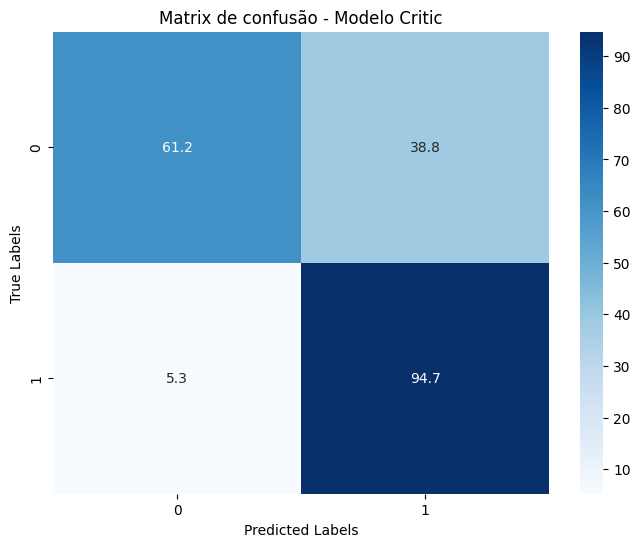

In [ ]:
best_epoch_critic = 2
model_config_critic = f'finetuned_CRITIC_{best_epoch_critic}.model'
best_model_critic = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_CRITIC, output_attentions=True, output_hidden_states=False)
best_model_critic.load_state_dict(torch.load(model_config_critic, map_location=torch.device('cpu')))
best_model_critic.to(DEVICE)

print("Melhor modelo")
_, preds, labels = Test(best_model_critic, dataloader_test_critic, DEVICE)
print(f'Test Loss: {_}')
preds_array = numpy.argmax(preds, axis=1)
val_accuracy_2 = accuracy_score(labels, preds_array)
print(f'Test Accuracy: {val_accuracy_2}')
val_balanced_accuracy_2 = balanced_accuracy_score(labels, preds_array)
print(f'Test Balanced Accuracy: {val_balanced_accuracy_2}')

ConfusionMatrix(labels, preds_array, title="Matrix de confusão - Modelo Critic", classes_list=distinct_sentiment_labels)

Modelo Audience

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-45-16a11f671bd8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

Melhor modelo
Test Loss: 1.6534529623461933
Test Accuracy: 0.45791682563906905
Test Balanced Accuracy: 0.3138093236569714


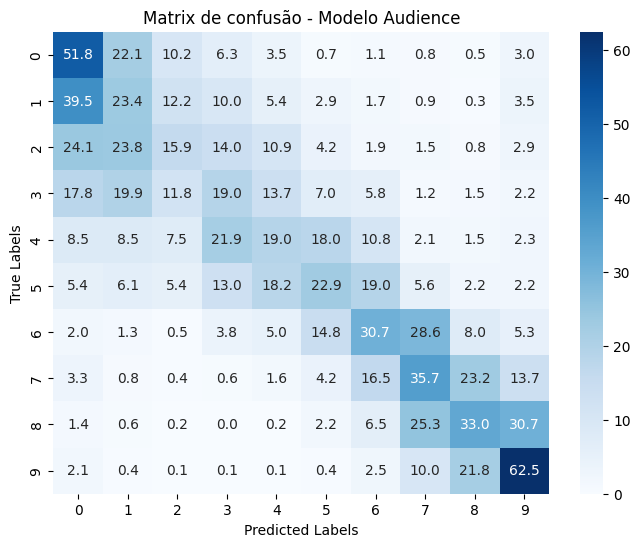

In [ ]:
best_epoch_audience = 8
model_config_audience = f'finetuned_AUDIENCE_{best_epoch_audience}.model'
best_model_audience = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_AUDIENCE, output_attentions=True, output_hidden_states=False)
best_model_audience.load_state_dict(torch.load(model_config_audience, map_location=torch.device('cpu')))
best_model_audience.to(DEVICE)

print("Melhor modelo")
_, preds, labels = Test(best_model_audience, dataloader_test_audience, DEVICE)
print(f'Test Loss: {_}')
preds_array = numpy.argmax(preds, axis=1)
val_accuracy_2 = accuracy_score(labels, preds_array)
print(f'Test Accuracy: {val_accuracy_2}')
val_balanced_accuracy_2 = balanced_accuracy_score(labels, preds_array)
print(f'Test Balanced Accuracy: {val_balanced_accuracy_2}')

ConfusionMatrix(labels, preds_array, title="Matrix de confusão - Modelo Audience", classes_list=sorted_rating_labels)

### Análise do Mecanismo de Atenção com BertViz



Modelo Critic

In [ ]:
input_ids=[]
for batch in dataloader_test_critic:
    input_ids.append(batch[0])

print(f'Modelo Critic')
correct_cases_critic = [(text, true, pred) for text, true, pred in zip(input_ids, labels_test_critic, preds_array) if true == pred]
print(f'Número de acertos: {len(correct_cases_critic)}')

decoded_correct_text_critic = TOKENIZER_CRITIC.decode(torch.tensor(correct_cases_critic[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso correto: {decoded_correct_text_critic}')

incorrect_cases_critic =[(text, true, pred) for text, true, pred in zip(input_ids, labels_test_critic, preds_array) if true != pred]
print(f'Número de incorretos: {len(incorrect_cases_critic)}')

decoded_incorrect_text_critic = TOKENIZER_CRITIC.decode(torch.tensor(incorrect_cases_critic[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso incorreto: {decoded_incorrect_text_critic}')

Modelo Critic
Número de acertos: 6
Texto caso correto: the brisk writing and pace keep it engaging, and it ’ s certainly more fun than getting called in for jury duty.
Número de incorretos: 87
Texto caso incorreto: gaslit works because it isn ' t only about the watergate break - in - in the show, it occurs as early as in episode 2 - but also about the people whose lives and careers were made or unmade by the scandal.


In [ ]:
model = best_model_critic
print("Análise para um comentário que foi corretamente predito")
inputs = TOKENIZER_CRITIC.encode(decoded_correct_text_critic, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_CRITIC.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)

print("Análise para um comentário que foi incorretamente predito")
inputs = TOKENIZER_CRITIC.encode(decoded_incorrect_text_critic, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_CRITIC.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)

Modelo Audience

In [ ]:
input_ids=[]
for batch in dataloader_test_audience:
    input_ids.append(batch[0])

print(f'Modelo Audience')
correct_cases_audience = [(text, true, pred) for text, true, pred in zip(input_ids, labels_test_audience, preds_array) if true == pred]
print(f'Número de acertos: {len(correct_cases_audience)}')

decoded_correct_text_audience = TOKENIZER_AUDIENCE.decode(torch.tensor(correct_cases_audience[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso correto: {decoded_correct_text_audience}')

incorrect_cases_audience =[(text, true, pred) for text, true, pred in zip(input_ids, labels_test_audience, preds_array) if true != pred]
print(f'Número de incorretos: {len(incorrect_cases_audience)}')

decoded_incorrect_text_audience = TOKENIZER_AUDIENCE.decode(torch.tensor(incorrect_cases_audience[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso incorreto: {decoded_incorrect_text_audience}')

In [ ]:
model = best_model_audience
print("Análise para um comentário que foi corretamente predito")
inputs = TOKENIZER_AUDIENCE.encode(decoded_correct_text_audience, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_AUDIENCE.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)

print("Análise para um comentário que foi incorretamente predito")
inputs = TOKENIZER_AUDIENCE.encode(decoded_incorrect_text_audience, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_AUDIENCE.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)